In [160]:
import jax.numpy as jnp
import numpy as np
import jax
from flax import nnx
import optax
from flax.training import train_state
import scipy
from scipy.spatial.distance import cdist
from scipy.integrate import RK45
import matplotlib.pyplot as plt

seed = 42
np.random.seed(42)

import equinox as eqx

In [151]:
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (out_size, in_size))
        self.bias = jax.random.normal(bkey, (out_size))

    def __call__(self, x):
        return self.weight @ x + self.bias


class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu):
        """
        architecture: [in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i]) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

class DeepONet(eqx.Module):
    branch: Branch
    trunk: MLP

    def __init__(self, branch_arch, trunk_arch, key, activation=jax.nn.relu):
        bkey, tkey = jax.random.split(key)
        trunk_arch = trunk_arch + [num_branches]
        self.branch = MLP(branch_arch, bkey, activation)
        self.trunk = MLP(trunk_arch, tkey, activation)

    def __call__(self, x):
        u= x[0]
        y = x[1]
        branch_out = self.branch(jnp.atleast_1d(u_vec))
        trunk_out = self.trunk(jnp.atleast_1d(y))
        return jnp.inner(branch_out, trunk_out) ## TODO: vectorize y component (vmap)


In [152]:
@jax.jit
@jax.grad
def loss_fn(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jnp.mean((y - pred_y) ** 2)

batch_size, in_size, out_size = 32,2,3
model = Linear(in_size, out_size, key = jax.random.PRNGKey(seed))
x = jnp.zeros((batch_size, in_size))
y = jnp.zeros((batch_size, out_size))

grads = loss_fn(model, x, y)

In [153]:
key = jax.random.key(0)
model = MLP([2,64,64,3], key)

x = jnp.ones((2,))
y = model(x)

In [154]:
y

Array([-55.826912 ,   2.7322528, -46.81471  ], dtype=float32)

In [155]:
x

Array([1., 1.], dtype=float32)

In [156]:
dataset = np.load("integral_dataset.npy")
# dataset[i] is traj i
# traj[j] = value
# value [k] = x_coord (0), u at x_coord (1), F at coord (2)
dataset[0].shape

(100, 3)

In [157]:
from sklearn.model_selection import train_test_split
X = dataset[:,:,:2]
y = dataset[:,:,2]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = seed)

In [158]:
X_train[0].shape

(100, 2)

In [159]:
y_train[0].shape

(100,)

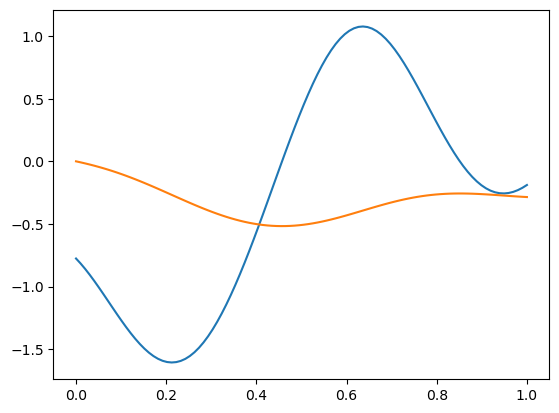

In [149]:
plt.plot(X_train[0,:,0], X_train[0,:,1])
plt.plot(X_train[0,:,0], y_train[0,:])

- time dependent data into dataset
- when does learned basis (trunk fxns) outperform basis via SVD? (POD or Reduced Order Model)
- time-dependent POD method for PDE solns


- once/if deeponet works, try on advection-based problem
    - will get sent burgers equation